In [1]:
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

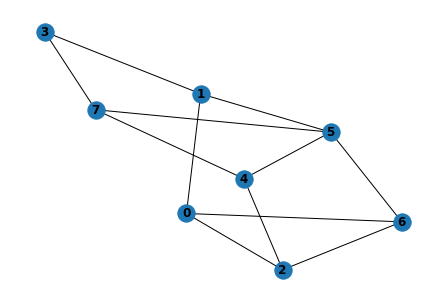

In [2]:
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
nx.draw(g, with_labels=True, font_weight='bold')

In [14]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

In [4]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma')
# circuit.svg()

In [5]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

In [6]:
# pylint: disable=W0104
circuit = build_hb(g, 'beta')
#circuit.svg()


In [7]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
# circuit.svg()

In [8]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

In [9]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

In [10]:
# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
# circ.svg()

In [16]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

In [12]:
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数

[WARNING] DEBUG(368,7f5550f24740,python):2022-06-20-06:32:29.586.557 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.
train step: 0 , cut: [5.999169]
train step: 10 , cut: [7.9966173]
train step: 20 , cut: [8.997269]
train step: 30 , cut: [9.332405]
train step: 40 , cut: [9.447646]
train step: 50 , cut: [9.515072]
train step: 60 , cut: [9.53264]
train step: 70 , cut: [9.5426655]
train step: 80 , cut: [9.543657]
train step: 90 , cut: [9.544959]
train step: 100 , cut: [9.545015]
train step: 110 , cut: [9.545161]
train step: 120 , cut: [9.545191]
train step: 130 , cut: [9.545198]
train step: 140 , cut: [9.545204]
train step: 150 , cut: [9.545207]
train step: 160 , cut: [9.545208]
train step: 170 , cut: [9.545208]
train step: 180 , cut: [9.545208]
train step: 190 , cut: [9.545208]


In [15]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)

{'g0': 0.17905602, 'b0': -1.1259468, 'g1': 0.3577803, 'b1': -0.85859597, 'g2': 0.42885056, 'b2': -0.6286932, 'g3': 0.48336348, 'b3': -0.31989393}
